# **Scraping the Tokyo Olympics**

## **Creating the data set**

In [33]:
# Import libraries to be used
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Url of the page that we want to scrape
url = "https://olympics.com/tokyo-2020/olympic-games/en/results/all-sports/medal-standings.htm"

# Send a request to the server to retrieve the page's html
r = requests.get(url)

soup = BeautifulSoup(r.text, 'lxml')

In [34]:
# Isolate the main medal standing table
table = soup.find('table', id = 'medal-standing-table')

# Get the link to each country's page from the table
links = table.find_all('a', class_ = 'country')

# Result is a shortened file path such as "../../../en/results/all-sports/noc-entries-united-states.htm"
# We need to restore the rest of the url through the following steps

url_lib = []

for link in links:
    link_ending = link.get('href').strip("/.")
    new_link = "https://olympics.com/tokyo-2020/olympic-games/" + link_ending
    url_lib.append(new_link) 
# Now the complete url to each country's page is stored in url_lib

In [ ]:
# Store the names of all countries in a separate list
country_names = [i.text.strip() for i in links]

In [49]:
import time

# Based on initial inspection, we want to get this information
headings = ["Country", "Discipline", "Athletes_F", "Atheltes_M", "Athletes_Total"]

# Create a Pandas dataframe with the above headings as columns
df = pd.DataFrame(columns = headings)

# Scrape each country's page
for url in url_lib:
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    table = soup.find('table', class_ = 'table table-schedule')

    # Remember country's position in the list of urls
    idx = url_lib.index(url)

    # Loop through each discipline in which the country competed
    for tr in table.find_all('tr')[1:-2]: # Careful to exclude the footer row

        # Get the discipline name
        discipline = tr.find('th').text.strip()
        # Get the athlete breakdown for the discipline: female, male, and total
        athletes = tr.find_all('td')
        athletes = [i.text.strip() for i in athletes]

        # Combine these items into one list
        athletes.insert(0, discipline)

        # Assign country's name to the beginning of the list
        athletes.insert(0, country_names[idx])

        # Return number of rows already in data frame
        length = len(df)

        # Store the list as a new row
        df.loc[length] = athletes

    # Access the table footer 
    footer = table.find('tfoot').find('tr')

    # Get size of the country's competing team
    totals = footer.find_all('td')
    totals = [i.text.strip() for i in totals]
    totals.insert(0, country_names[idx])

    length = len(df)
    df.loc[length] = totals

    # Delay next page request by 10 sec
    time.sleep(10)

In [4]:
# Export final dataframe as csv file
df.to_csv('olympicsdata.csv')

## **Exploratory analysis**

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# Import the csv file created previously
data = pd.read_csv('olympicsdata.csv')
del data["Unnamed: 0"]
data.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
0,United States of America,3x3 Basketball,4,0,4
1,United States of America,Archery,3,3,6
2,United States of America,Artistic Gymnastics,6,5,11
3,United States of America,Artistic Swimming,2,0,2
4,United States of America,Athletics,65,63,128


In [37]:
# Create a subset of the data with each country's competing team size
totals = data[data["Discipline"] == "Total"]
totals.head()

,Country,Discipline,Athletes_F,Athletes_M,Athletes_Total
43,United States of America,Total,338,288,626
84,People's Republic of China,Total,288,125,413
130,Japan,Total,286,316,602
165,Great Britain,Total,205,178,383
203,ROC,Total,187,149,336


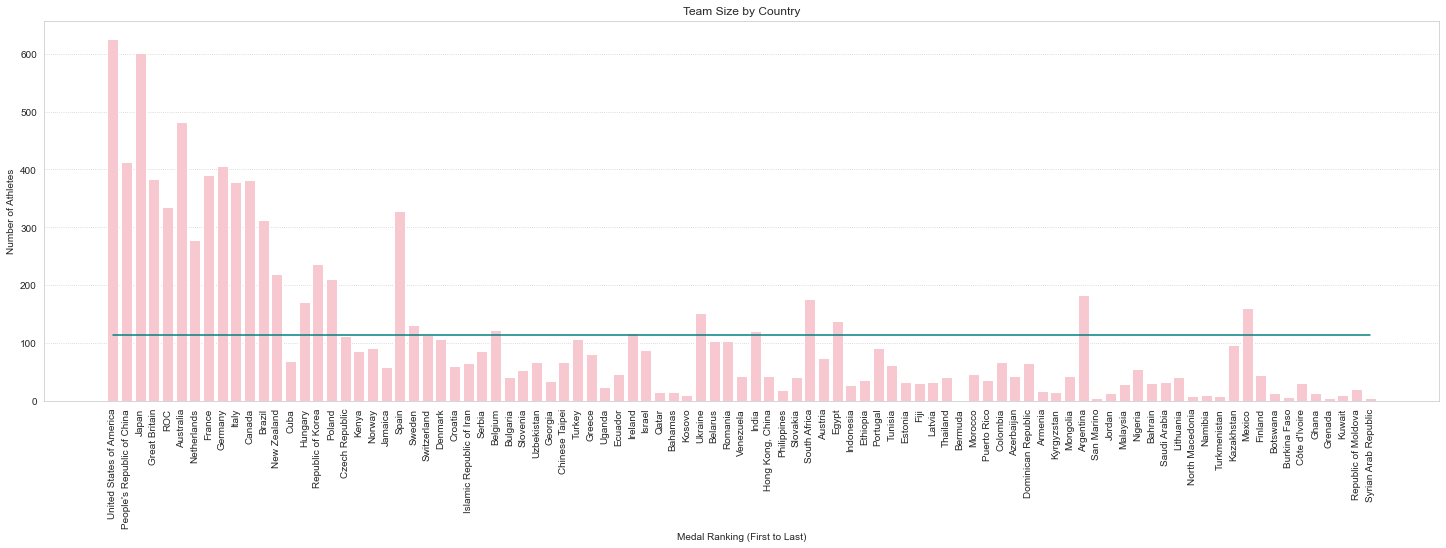

In [61]:
fig, axs = plt.subplots(figsize = (25,7))

# Plot a simple bar chart showing team size by country
chart = sns.barplot(x="Country", y="Athletes_Total", color="pink", data=totals)
# Rotate x-axis labels from horizontal position to improve readability
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
# Set plot titles
chart.set(title='Team Size by Country', ylabel='Number of Athletes', xlabel='Medal Ranking (First to Last)')

# Calculate average team size out of all countries
avg = sum(totals['Athletes_Total'])/len(totals)
# Create column with average value to be added to dataframe
i = 0
avg_list = []
while i < len(totals):
    avg_list.append(avg)
    i = i + 1
# Add column to dataframe
totals_2 = totals.assign(Average = avg_list)
# Plot average line
chart = sns.lineplot(x="Country", y="Average", color="teal", data=totals_2)

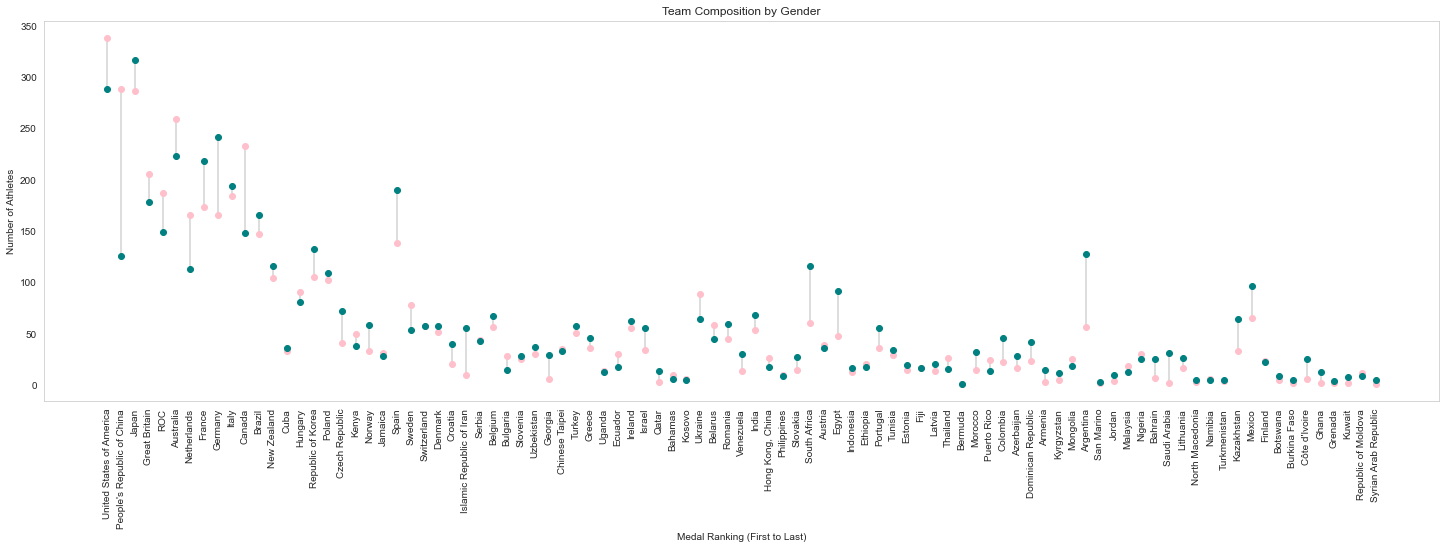

In [59]:
fig, axs = plt.subplots(figsize = (25,7))
axs.plot(totals['Country'], totals['Athletes_F'], marker="o", linewidth=0, color='pink')
axs.plot(totals['Country'], totals['Athletes_M'], marker="o", linewidth=0, color='teal')

minimum = []
i = 0
while i < len(totals):
    minimum.append(min(totals['Athletes_F'].iloc[i], totals['Athletes_M'].iloc[i]))
    i = i + 1
maximum = []
j = 0
while j < len(totals):
    maximum.append(max(totals['Athletes_F'].iloc[j], totals['Athletes_M'].iloc[j]))
    j = j + 1

plt.vlines(x=totals['Country'], ymin=minimum, ymax=maximum, color='lightgrey')
plt.xticks(rotation=90)
plt.title("Team Composition by Gender")
plt.xlabel("Medal Ranking (First to Last)")
plt.ylabel("Number of Athletes")
plt.grid(color='lightgrey', linewidth=0.5)

plt.show()